<h1 align="center">MSIN0114: Business Analytics Consulting Project/Dissertation</h1>

<h3 align="center">Web Scrapping for Wrike Review on g2.com and trustradius.com</h3>
<br>

 <h3 align="center">Jun 2021</h3>
 <h3 align="center">Github repository:</h3>

<h3>Table of Contents</h3>

* [1. Web Scrapping for Wrike](#1.-Web-Scrapping-for-Wrike)
* [2. Load Scrapped Data](#2.-Load-Scrapped-Data)
* [3. Initial Cleaning of Dataset](#3.-Initial-Cleaning-of-Dataset)
* [4. Upload Data into PostgreSQL Database](#4.-Upload-Data-into-PostgreSQL-Database) 
* [5. Save Dataset as csv for Local Access](#5.-Save-Dataset-as-csv-for-Local-Access)


In [1]:
# Basic packages 
import numpy as np                   
import pandas as pd              
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt    
import seaborn as sns

import plotly.express as px

# RDS Database Connection 
import psycopg2


## 1. Web Scrapping for Wrike

Web Scrapping code for Wrike stored as spider_5.py and spider_6.py

In [2]:
!python Spider_5.py

1 {'Name': 'Kevin W', 'Position': 'Owner Oil & Energy', 'Company': 'Small-Business (50 or fewer emp.)', 'Rating': 'stars-10', 'Date': 'May 18, 2021', 'Title': '"Wrike has helped our company track everything we do. Tracking all our design work."', 'Review': 'What do you like best? Collaboration and objective evidence for every state of the project. We are an ISO company so having all this data for the auditor helps us so much with our compliance. We received our first ISO audit since implementing Wrike on a small scale and our auditor was so impressed he said we would recommend this program to other companies struggling to capture as much data as possible. All meetings are captured, phone calls transcribed. Approvals are submitted in real time and the whole team can see the status of anything at a glance. Notifications help us to stay up to date along with use of Gant charts where they apply.  Review collected by and hosted on G2.com. What do you dislike? The interface continues to evol

Traceback (most recent call last):
  File "Spider_5.py", line 80, in <module>
    parse_1(t)
  File "Spider_5.py", line 46, in parse_1
    print(count, p_review)
UnicodeEncodeError: 'gbk' codec can't encode character '\xe7' in position 53: illegal multibyte sequence


18 {'Name': 'Alex G', 'Position': 'GM', 'Company': 'Small-Business (50 or fewer emp.)', 'Rating': 'stars-8', 'Date': 'Feb 18, 2021', 'Title': '"Brings Efficiency to Project Management"', 'Review': ''}
19 {'Name': 'Cody D', 'Position': 'Sr Project Manager', 'Company': 'Mid-Market (51-1000 emp.)', 'Rating': 'stars-9', 'Date': 'Feb 16, 2021', 'Title': '"Great tool to optimize the management of your projects."', 'Review': "What do you like best? The opportunity to plan and share your own projects with the team. Often delegate roles to handle the staff and those that may assist you in finishing the job. He has managed my team's activities effectively, I can add third partners and monitor a project's immediate output. Before the shipping dates, I will alert my customers. I schedule and my customers chronologically.  Review collected by and hosted on G2.com. What do you dislike? Everything I did with the app so far is positive, I have no drawbacks to comment. However, I believe that a way of 

In [3]:
!python Spider_6.py

## 2. Load Scrapped Data

In [4]:
# import monday data
g2_wrike= pd.read_excel ('./html_data/Wrike/Wrike_g2.xls',index_col=0)
tr_wrike=pd.read_excel('./html_data/Wrike/Wrike_tr.xls',index_col=0)


## 3. Initial Cleaning of Dataset

Initial Cleaning of dataset is required before the data is stored in a PostgreSQL database. This is to ensure the data matches the desired data type specified in the Schema Customer Review

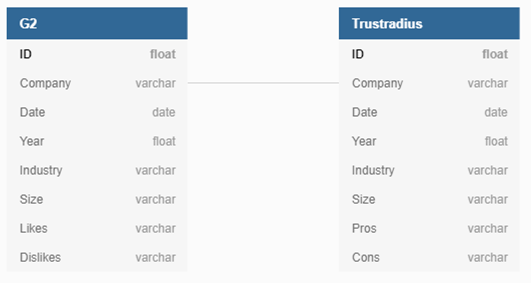

In [5]:
# Extract size from Column Company

g2_wrike['size'] = g2_wrike.Company.str.extract('(\d+)')


# Replace data with no value as missing t
g2_wrike.loc[g2_wrike['size'].isnull(), 'size'] = -1
g2_wrike['size']=g2_wrike['size'].astype('int')

# Categorise the size according the definition provided by G2.com 
g2_wrike['Size'] = g2_wrike['size'].apply(lambda x: 
                              'Med-Market' if x in range(51,1000) else 
                              'Small-Business' if x in range(0,51) else 
                              'Missing' if x==-1 else
                              'Enterprise' )
# Drop repeated columns 

g2_wrike[['Pros', 'Cons','Recommendation','Problem']] = g2_wrike['Review'].str.split('Review collected by and hosted on G2.com', 3, expand=True)
g2_wrike.drop(columns = ['size','Company','Rating','Title','Review','Recommendation','Problem','Name','Recommendation'],inplace = True)

# Rename columns to matches names in Schema
g2_wrike.rename(columns ={'Position':'Industry'},inplace = True)

# Create column ID and Company 
g2_wrike.reset_index(drop = True, inplace =True)
g2_wrike['Company'] = 'Wrike'
g2_wrike['ID'] = 'G2_'+ g2_wrike['Company']+ '_' +g2_wrike.index.astype(str)

# Extract year from column Date for column Year 
g2_wrike['Date']=pd.to_datetime(g2_wrike['Date'])
g2_wrike['Year'] = g2_wrike['Date'].dt.year.astype(str)

In [6]:
g2_wrike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Industry  743 non-null    object        
 1   Date      1373 non-null   datetime64[ns]
 2   Size      1373 non-null   object        
 3   Pros      1366 non-null   object        
 4   Cons      1366 non-null   object        
 5   Company   1373 non-null   object        
 6   ID        1373 non-null   object        
 7   Year      1373 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 85.9+ KB


A total of 1373 reviews are collected from Trustradius.com for monday.com, https://www.trustradius.com/products/wrike/reviews

In [7]:
# Extract the size of the column from the industry column 
# Small-Business: 50 or fewer emp
# Mid-market: 51-1000 emp
# Enterprise: >1000 emp 
tr_wrike.fillna('Missing',inplace = True )
tr_wrike['size1'] = tr_wrike.industry.str.extract('(-\d+)')
tr_wrike['size2'] = tr_wrike.size1.str.extract('(\d+)')
tr_wrike['size2'] = tr_wrike['size2'].fillna(0)
tr_wrike['size0'] = tr_wrike.industry.str.extract('(\d+,\d+)')
tr_wrike['size'] = np.where(tr_wrike.size2 == 0,tr_wrike.size0,tr_wrike.size2)
tr_wrike.loc[tr_wrike['size'].isnull(), 'size'] = -1
tr_wrike.drop(['size1','size2','size0'], axis=1, inplace=True)
tr_wrike['size'] = np.where(tr_wrike['size'] == '10,001',10001,tr_wrike['size'])
tr_wrike['size']=tr_wrike['size'].astype('int')

# Categorise the size according the definition provided by G2.com 
tr_wrike['Size'] = tr_wrike['size'].apply(lambda x: 
                              'Med-Market' if x in range(51,1000) else 
                              'Small-Business' if x in range(0,51) else 
                              'Missing' if x==-1 else
                              'Enterprise' )

tr_wrike.drop(['size'],axis = 1, inplace = True)

tr_wrike.rename(columns ={'review-date':'Date',},inplace = True)


# Remove the nunber of employees information from the industry column 
tr_wrike[['Industry', 'Number of employees']] = tr_wrike['industry'].str.split(',', 1, expand=True)


# Drop repeated columns 
tr_wrike.drop(columns = ['name','industry-type','industry','Number of employees'],inplace = True)

# Create column ID and Company 
tr_wrike.reset_index(drop = True, inplace =True)
tr_wrike['Company'] = 'Wrike'
tr_wrike['ID'] = 'TR_'+ tr_wrike['Company']+ '_' +tr_wrike.index.astype(str)

# Extract year from column Date for column Year 
tr_wrike['Date']=pd.to_datetime(tr_wrike['Date'])
tr_wrike['Year'] = tr_wrike['Date'].dt.year.astype(str)


In [8]:
tr_wrike.head()

,Date,Pros,Cons,Size,Industry,Company,ID,Year
0,2021-04-27,Communication and Track organization across th...,Improve communication on new features and upda...,Enterprise,Marketing & Advertising,Wrike,TR_Wrike_0,2021
1,2021-03-04,"Timeline creation, editing, updating.Template ...",Overall UI is not as appealing as other compet...,Enterprise,Hospital & Health Care,Wrike,TR_Wrike_1,2021
2,2020-12-02,Keeps our campaigns organizedSpeeds up the app...,Notification emails would be better if they we...,Med-Market,Printing,Wrike,TR_Wrike_2,2020
3,2021-04-26,Not sure I have anything to say here,[I feel] their customer service is ruthless an...,Small-Business,Hospital & Health Care Company,Wrike,TR_Wrike_3,2021
4,2021-05-12,Task ManagementGantt ChartDue Dates/Notifications,Onboarding process was terrible: very unflexib...,Med-Market,Real Estate Company,Wrike,TR_Wrike_4,2021


In [9]:
tr_wrike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      177 non-null    datetime64[ns]
 1   Pros      177 non-null    object        
 2   Cons      177 non-null    object        
 3   Size      177 non-null    object        
 4   Industry  177 non-null    object        
 5   Company   177 non-null    object        
 6   ID        177 non-null    object        
 7   Year      177 non-null    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 11.2+ KB


A total of 177 reviews are collected from Trustradius for Wrike, https://www.g2.com/products/wrike/reviews[].

## 4. Upload Data into PostgreSQL Database

In [14]:
# Enter credential for database 
engine = psycopg2.connect(
    host="database-1.cg80f0qtitmf.eu-west-1.rds.amazonaws.com",
    user="postgres",
    password="chenziyi",
    port=5432
)

In [58]:
cur = engine.cursor()
cur.execute(""" 
     
     
     CREATE SCHEMA IF NOT EXISTS schema_Customer_Review;
     
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.G2 (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.Trustradius (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
      """)

print("Table created successfully")

engine.commit()
engine.close()

Table created successfully


In [11]:
# Insert scrapped data into the database 
# Wrike for Table g2


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.g2(Industry, Date, Size, Pros, Cons, Company, ID, Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""



for index in range(len(g2_wrike)):
    obj = []
    l=[]
    for col in g2_wrike.columns:
        l.append(g2_wrike[col][index])
    obj.append(l)
    cur.executemany(s, obj)
    engine.commit()
    
print("Insert successfully")

engine.close()

Insert successfully


In [13]:
# Insert scrapped data into the database 
# Wrike for Table Trustradius


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.Trustradius(Date, Pros, Cons, Size, Industry, Company, ID,Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""

print("Insert successfully")

for index in range(len(tr_wrike)):
    obj = []
    l=[]
    for col in tr_wrike.columns:
        l.append(tr_wrike[col][index])
    obj.append(l)


    cur.executemany(s, obj)
    engine.commit()
engine.close()

Insert successfully


In [15]:
TR= pd.read_sql("select * from schema_Customer_review.Trustradius", engine)
engine.close()

In [16]:
TR

,id,company,date,year,industry,size,pros,cons
0,TR_Monday_0,Monday,2021-06-08,2021,Apparel & Fashion,Small-Business,We can push updates and information for design...,The way emails display after being pushed as a...
1,TR_Monday_1,Monday,2021-06-07,2021,Computer Software,Med-Market,VersitileFlexibleEasy-to-use,"Software Integrations, I feel like if we could..."
2,TR_Monday_2,Monday,2021-06-05,2021,Education Management,Med-Market,"Project management of all our past, ongoing, a...","If I recall, there were some sub item areas th..."
3,TR_Monday_3,Monday,2021-05-20,2021,Retail,Small-Business,Notifications - My boards are set up to update...,Biggest Con - Adding seats to monday.comLet me...
4,TR_Monday_4,Monday,2021-05-19,2021,Higher Education,Small-Business,Collaboration. I have never used a platform wh...,Automations. There are a few things I'd like t...
...,...,...,...,...,...,...,...,...
1337,TR_Wrike_172,Wrike,2014-07-30,2014,Legal Services Company,Small-Business,Integration with Google Apps. The ability to c...,Provides no budgeting capabilities. Therefore ...
1338,TR_Wrike_173,Wrike,2015-03-01,2015,Information Technology and Services Company,Small-Business,I found its better than the previous project m...,Missing
1339,TR_Wrike_174,Wrike,2014-11-14,2014,Information Technology and Services Company,Small-Business,SubtasksTracking and updating tasks you follow...,Creating projects
1340,TR_Wrike_175,Wrike,2014-06-06,2014,Insurance Company,Med-Market,The timeline view enables us to schedule proje...,I find the built in time tracker awkward to us...


As shown by the query, the data for Wrike is added on top of the data for Monday.com and Asana, the review for Wrike in table Trustradius can be separated using information in column 'Company' and the unique ID assigned.

## 5. Save Dataset as csv for Local Access

In [17]:
# Save as csv for local access 
df_Wrike  = pd.concat([tr_wrike, g2_wrike])
df_Wrike.info()
df_Wrike.to_csv('Wrike review.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 0 to 1372
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1550 non-null   datetime64[ns]
 1   Pros      1543 non-null   object        
 2   Cons      1543 non-null   object        
 3   Size      1550 non-null   object        
 4   Industry  920 non-null    object        
 5   Company   1550 non-null   object        
 6   ID        1550 non-null   object        
 7   Year      1550 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 109.0+ KB


In [18]:
df_Wrike.head()

,Date,Pros,Cons,Size,Industry,Company,ID,Year
0,2021-04-27,Communication and Track organization across th...,Improve communication on new features and upda...,Enterprise,Marketing & Advertising,Wrike,TR_Wrike_0,2021
1,2021-03-04,"Timeline creation, editing, updating.Template ...",Overall UI is not as appealing as other compet...,Enterprise,Hospital & Health Care,Wrike,TR_Wrike_1,2021
2,2020-12-02,Keeps our campaigns organizedSpeeds up the app...,Notification emails would be better if they we...,Med-Market,Printing,Wrike,TR_Wrike_2,2020
3,2021-04-26,Not sure I have anything to say here,[I feel] their customer service is ruthless an...,Small-Business,Hospital & Health Care Company,Wrike,TR_Wrike_3,2021
4,2021-05-12,Task ManagementGantt ChartDue Dates/Notifications,Onboarding process was terrible: very unflexib...,Med-Market,Real Estate Company,Wrike,TR_Wrike_4,2021


In total, 1550 reviews are collect for Wrike from both g2.com and trustraidus.com